### Distributed MCMC Retrieval

This notebook runs the MCMC retrievals on a local cluster using `ipyparallel`.


In [1]:
import ipyparallel as ipp
c = ipp.Client(profile='mpi')
lview = c.load_balanced_view()

## Retrieval Setup

In [2]:
%%px
%env ARTS_BUILD_PATH=/home/simonpf/build/arts
%env ARTS_INCLUDE_PATH=/home/simonpf/src/atms_simulations/:/home/simonpf/src/arts_clean/controlfiles
%env ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
%env OMP_NUM_THREADS=1

import sys
sys.path.insert(1,"/home/simonpf/src/atms_simulations/")
sys.path.insert(1, "/home/simonpf/src/typhon/")

import os
os.chdir("/home/simonpf/src/atms_simulations")

# This is important otherwise engines just crash.
import matplotlib; matplotlib.use("agg")

[stdout:0] 
env: ARTS_BUILD_PATH=/home/simonpf/build/arts
env: ARTS_INCLUDE_PATH=/home/simonpf/src/atms_simulations/:/home/simonpf/src/arts_clean/controlfiles
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: OMP_NUM_THREADS=1
[stdout:1] 
env: ARTS_BUILD_PATH=/home/simonpf/build/arts
env: ARTS_INCLUDE_PATH=/home/simonpf/src/atms_simulations/:/home/simonpf/src/arts_clean/controlfiles
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: OMP_NUM_THREADS=1
[stdout:2] 
env: ARTS_BUILD_PATH=/home/simonpf/build/arts
env: ARTS_INCLUDE_PATH=/home/simonpf/src/atms_simulations/:/home/simonpf/src/arts_clean/controlfiles
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: OMP_NUM_THREADS=1
[stdout:3] 
env: ARTS_BUILD_PATH=/home/simonpf/build/arts
env: ARTS_INCLUDE_PATH=/home/simonpf/src/atms_simulations/:/home/simonpf/src/arts_clean/controlfiles
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: OMP_NUM_THREADS=1
[stdout:4] 
env: ARTS_BUILD_PATH=/home/simonpf/build/arts
env: ARTS_INCLUDE_PATH

In [3]:
from typhon.arts.workspace import Workspace
import atms
import numpy as np

ws = Workspace()
channels = [0,15,16,17,19]
atms.setup_atmosphere(ws)
atms.setup_sensor(ws, channels)
atms.checks(ws)
ws.yCalc()

Loading ARTS API from: /home/simonpf/build/arts/src/libarts_api.so
ARTS[56764992]: Executing /home/simonpf/src/arts/controlfiles/general/general.arts
ARTS[56764992]: {
ARTS[56764992]: - verbosityInit
ARTS[56764992]: - scat_speciesSet
ARTS[56764992]: - MatrixSet
ARTS[56764992]: - Tensor4SetConstant
ARTS[56764992]: - ArrayOfStringSet
ARTS[56764992]: - Touch
ARTS[56764992]: - FlagOff
ARTS[56764992]: - MatrixSet
ARTS[56764992]: - NumericSet
ARTS[56764992]: - ArrayOfStringSet
ARTS[56764992]: - Tensor3SetConstant
ARTS[56764992]: - Tensor3SetConstant
ARTS[56764992]: - Tensor3SetConstant
ARTS[56764992]: - Tensor3SetConstant
ARTS[56764992]: - Tensor3SetConstant
ARTS[56764992]: - Tensor3SetConstant
ARTS[56764992]: - IndexSet
ARTS[56764992]: - IndexSet
ARTS[56764992]: - IndexSet
ARTS[56764992]: - IndexSet
ARTS[56764992]: - FlagOff
ARTS[56764992]: - output_file_formatSetAscii
ARTS[56764992]: - StringSet
ARTS[56764992]: - IndexSet
ARTS[56764992]: - abs_lineshapeDefine
ARTS[56764992]: - NumericSet
A

In [4]:
%%px
from typhon.arts.workspace import Workspace
import atms
import numpy as np

ws = Workspace()
channels = [0,15,16,17,19]
atms.setup_atmosphere(ws)
atms.setup_sensor(ws, channels)
atms.checks(ws)
ws.yCalc()

[stdout:0] 
Loading ARTS API from: /home/simonpf/build/arts/src/libarts_api.so
ARTS[23163696]: Executing /home/simonpf/src/arts_clean/controlfiles/general/general.arts
ARTS[23163696]: {
ARTS[23163696]: - verbosityInit
ARTS[23163696]: - scat_speciesSet
ARTS[23163696]: - MatrixSet
ARTS[23163696]: - Tensor4SetConstant
ARTS[23163696]: - ArrayOfStringSet
ARTS[23163696]: - Touch
ARTS[23163696]: - FlagOff
ARTS[23163696]: - MatrixSet
ARTS[23163696]: - NumericSet
ARTS[23163696]: - ArrayOfStringSet
ARTS[23163696]: - Tensor3SetConstant
ARTS[23163696]: - Tensor3SetConstant
ARTS[23163696]: - Tensor3SetConstant
ARTS[23163696]: - Tensor3SetConstant
ARTS[23163696]: - Tensor3SetConstant
ARTS[23163696]: - Tensor3SetConstant
ARTS[23163696]: - IndexSet
ARTS[23163696]: - IndexSet
ARTS[23163696]: - IndexSet
ARTS[23163696]: - IndexSet
ARTS[23163696]: - FlagOff
ARTS[23163696]: - output_file_formatSetAscii
ARTS[23163696]: - StringSet
ARTS[23163696]: - IndexSet
ARTS[23163696]: - abs_lineshapeDefine
ARTS[2316369

## A Priori State

The simulations are based on the a priori assumptions, that the profiles of specific humidity, temperature and ozone vary independently and that the relative variations can be described by Log-Gaussian distributions.

In [5]:
%%px
qt_mean = np.load("data/qt_mean.npy").ravel()
qt_cov     = np.load("data/qt_cov.npy")
qt_cov_inv  = np.linalg.inv(qt_cov)

## Jumping Functions

The jumping functions are used inside the MCMC iteration and propose new atmospheric states for specific humidity, temperature and ozone, respectively. The proposed states are generated from random walks that use scaled versions of the a priori covariances.

In [6]:
%%px
import numpy as np
from typhon.retrieval.mcmc import RandomWalk
c = (1.0 / np.sqrt(qt_mean.size)) ** 2
rw_qt  = RandomWalk(c * qt_cov)

def j_qt(ws, x, revert = False):
    if revert:
        x_new = x
    else:
        x_new = rw_qt.step(x)
    q_new = (np.exp(x_new[14::-1]).reshape((15,)))
    q_new = atms.mmr2vmr(ws, q_new, "h2o")
    ws.vmr_field.value[0, :, 0, 0] = q_new
    ws.t_field.value[:, 0, 0] = x_new[:14:-1]
    ws.sst = np.maximum(ws.t_field.value[0, 0, 0], 270.0)
    return x_new

## A Priori Distributions

These functions return the likelihood (up to an additive constant) of a given state for each of the variables. Note that the states of specific humidity, temperature and ozone are given by the logs of the relative variations. 

In [7]:
%%px
def p_a_qt(x):
    dx = x - qt_mean
    l = - 0.5 * np.dot(dx, np.dot(qt_cov_inv, dx))
    return l

## Measurement Uncertainty

We assume that uncertainty of the measured brightness temperatures can be described by independent Gaussian error with a standard deviation of $1 K$.

In [8]:
%%px
covmat_y = np.diag(np.ones(len(channels)))
covmat_y_inv = np.linalg.inv(covmat_y)

def p_y(y, yf):
    dy = y - yf
    l  = - 0.5 * np.dot(dy, np.dot(covmat_y_inv, dy))
    return l

# Running MCMC


### The Simulated Measurement

For the simulated measurement, we sample a state from the a priori distribution of atmsopheric states and simulate the measured brightness temperatures.

A simple heuristic is applied to ensure that reasonable acceptance rates are obtained during the MCMC simulations. After the initial burn-in phase, 1000 simulation steps are performed. If the acceptance rates during this simulation are too low/high that covariance matrices of the corresponding random walks are scaled by a factor 0.1 / 9.0, respectively.

In [9]:
%%px
def adapt_covariances(a):
    if (np.sum(a[:, 0]) / a.shape[0]) < 0.2:
        rw_qt.covmat *= 0.7
    if (np.sum(a[:, 0]) / a.shape[0]) > 0.4:
        rw_qt.covmat *= 1.5

In [10]:
%%px
from typhon.retrieval.mcmc import MCMC
from atms import vmr2cd

dist = atms.StateDistribution()
n_burn_in = 500
n_prod    = 5000
drop      = 10

In [11]:
from typhon.retrieval.mcmc import MCMC
from atms import vmr2cd

def run_retrieval(i):
   
    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c * qt_cov)

    # Generate True State
    dist.sample(ws)
    ws.yCalc()
    y_true   = np.copy(ws.y)
    q_true  = np.copy(ws.vmr_field.value[0, :, 0, 0].ravel())
    t_true  = np.copy(ws.t_field.value[:, 0, 0].ravel())
    cwv_true = atms.vmr2cd(ws)
    
    dist.a_priori(ws)
    qt = np.zeros(qt_mean.size)

    # Add Noise
    y_true += np.random.randn(*y_true.shape)
    
    #try:
    mcmc  = MCMC([[qt, p_a_qt, j_qt]], y_true, p_y, [vmr2cd])

    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_1, s_1, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_2, s_2, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_3, s_3, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_4, s_4, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_5, s_5, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_6, s_6, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_7, s_7, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_8, s_8, _, _ = mcmc.run(ws, n_prod)

    profiles_q =  np.stack([hist_1[0][::drop, :15],
                            hist_2[0][::drop, :15],
                            hist_3[0][::drop, :15],
                            hist_4[0][::drop, :15],
                            hist_5[0][::drop, :15],
                            hist_6[0][::drop, :15],
                            hist_7[0][::drop, :15],
                            hist_8[0][::drop, :15]])
    profiles_t =  np.stack([hist_1[0][::drop, 15:],
                            hist_2[0][::drop, 15:],
                            hist_3[0][::drop, 15:],
                            hist_4[0][::drop, 15:],
                            hist_5[0][::drop, 15:],
                            hist_6[0][::drop, 15:],
                            hist_7[0][::drop, 15:],
                            hist_8[0][::drop, 15:]])
    cwv = np.stack([s_1[::drop], s_2[::drop], s_3[::drop], s_4[::drop],
                    s_5[::drop],s_6[::drop],s_7[::drop],s_8[::drop]], axis=0)
    return y_true, q_true, cwv_true, profiles_q, profiles_t, cwv    

## Running the Retrievals

In [15]:
import numpy as np
ids = np.arange(2500)
rs = lview.map_async(run_retrieval, ids)

In [16]:
from atms import create_output_file

root_group, v_y_true, v_cwv_true, v_cwv ,v_h2o = create_output_file("data/mcmc_retrievals_5.nc", 5, 15)
for y_true, h2o_true, cwv_true, profiles_q, profiles_t, cwv in rs:
    if not y_true is None:
        t = v_cwv_true.shape[0]
        print("saving simulation: " + str(t))
        steps=cwv.size
        v_y_true[t,:]      = y_true
        ws.vmr_field.value[0,:,:,:] = h2o_true.reshape(-1,1,1)
        v_cwv_true[t]      = cwv_true
        v_cwv[t, :steps]   = cwv[:]
        v_h2o[t, :steps,:] = profiles_q.ravel().reshape(-1, 15)
    else:
        print("failure in simulation: " + str(t))
        print(h2o_true)
        print(cwv_true)
        print(profiles)

loading existing file: data/mcmc_retrievals_5.nc
saving simulation: 5000
saving simulation: 5001
saving simulation: 5002
saving simulation: 5003
saving simulation: 5004
saving simulation: 5005
saving simulation: 5006
saving simulation: 5007
saving simulation: 5008
saving simulation: 5009
saving simulation: 5010
saving simulation: 5011
saving simulation: 5012
saving simulation: 5013
saving simulation: 5014
saving simulation: 5015
saving simulation: 5016
saving simulation: 5017
saving simulation: 5018
saving simulation: 5019
saving simulation: 5020
saving simulation: 5021
saving simulation: 5022
saving simulation: 5023
saving simulation: 5024
saving simulation: 5025
saving simulation: 5026
saving simulation: 5027
saving simulation: 5028
saving simulation: 5029
saving simulation: 5030
saving simulation: 5031
saving simulation: 5032
saving simulation: 5033
saving simulation: 5034
saving simulation: 5035
saving simulation: 5036
saving simulation: 5037
saving simulation: 5038
saving simulati

saving simulation: 5340
saving simulation: 5341
saving simulation: 5342
saving simulation: 5343
saving simulation: 5344
saving simulation: 5345
saving simulation: 5346
saving simulation: 5347
saving simulation: 5348
saving simulation: 5349
saving simulation: 5350
saving simulation: 5351
saving simulation: 5352
saving simulation: 5353
saving simulation: 5354
saving simulation: 5355
saving simulation: 5356
saving simulation: 5357
saving simulation: 5358
saving simulation: 5359
saving simulation: 5360
saving simulation: 5361
saving simulation: 5362
saving simulation: 5363
saving simulation: 5364
saving simulation: 5365
saving simulation: 5366
saving simulation: 5367
saving simulation: 5368
saving simulation: 5369
saving simulation: 5370
saving simulation: 5371
saving simulation: 5372
saving simulation: 5373
saving simulation: 5374
saving simulation: 5375
saving simulation: 5376
saving simulation: 5377
saving simulation: 5378
saving simulation: 5379
saving simulation: 5380
saving simulatio

saving simulation: 5682
saving simulation: 5683
saving simulation: 5684
saving simulation: 5685
saving simulation: 5686
saving simulation: 5687
saving simulation: 5688
saving simulation: 5689
saving simulation: 5690
saving simulation: 5691
saving simulation: 5692
saving simulation: 5693
saving simulation: 5694
saving simulation: 5695
saving simulation: 5696
saving simulation: 5697
saving simulation: 5698
saving simulation: 5699
saving simulation: 5700
saving simulation: 5701
saving simulation: 5702
saving simulation: 5703
saving simulation: 5704
saving simulation: 5705
saving simulation: 5706
saving simulation: 5707
saving simulation: 5708
saving simulation: 5709
saving simulation: 5710
saving simulation: 5711
saving simulation: 5712
saving simulation: 5713
saving simulation: 5714
saving simulation: 5715
saving simulation: 5716
saving simulation: 5717
saving simulation: 5718
saving simulation: 5719
saving simulation: 5720
saving simulation: 5721
saving simulation: 5722
saving simulatio

saving simulation: 6024
saving simulation: 6025
saving simulation: 6026
saving simulation: 6027
saving simulation: 6028
saving simulation: 6029
saving simulation: 6030
saving simulation: 6031
saving simulation: 6032
saving simulation: 6033
saving simulation: 6034
saving simulation: 6035
saving simulation: 6036
saving simulation: 6037
saving simulation: 6038
saving simulation: 6039
saving simulation: 6040
saving simulation: 6041
saving simulation: 6042
saving simulation: 6043
saving simulation: 6044
saving simulation: 6045
saving simulation: 6046
saving simulation: 6047
saving simulation: 6048
saving simulation: 6049
saving simulation: 6050
saving simulation: 6051
saving simulation: 6052
saving simulation: 6053
saving simulation: 6054
saving simulation: 6055
saving simulation: 6056
saving simulation: 6057
saving simulation: 6058
saving simulation: 6059
saving simulation: 6060
saving simulation: 6061
saving simulation: 6062
saving simulation: 6063
saving simulation: 6064
saving simulatio

saving simulation: 6366
saving simulation: 6367
saving simulation: 6368
saving simulation: 6369
saving simulation: 6370
saving simulation: 6371
saving simulation: 6372
saving simulation: 6373
saving simulation: 6374
saving simulation: 6375
saving simulation: 6376
saving simulation: 6377
saving simulation: 6378
saving simulation: 6379
saving simulation: 6380
saving simulation: 6381
saving simulation: 6382
saving simulation: 6383
saving simulation: 6384
saving simulation: 6385
saving simulation: 6386
saving simulation: 6387
saving simulation: 6388
saving simulation: 6389
saving simulation: 6390
saving simulation: 6391
saving simulation: 6392
saving simulation: 6393
saving simulation: 6394
saving simulation: 6395
saving simulation: 6396
saving simulation: 6397
saving simulation: 6398
saving simulation: 6399
saving simulation: 6400
saving simulation: 6401
saving simulation: 6402
saving simulation: 6403
saving simulation: 6404
saving simulation: 6405
saving simulation: 6406
saving simulatio

saving simulation: 6708
saving simulation: 6709
saving simulation: 6710
saving simulation: 6711
saving simulation: 6712
saving simulation: 6713
saving simulation: 6714
saving simulation: 6715
saving simulation: 6716
saving simulation: 6717
saving simulation: 6718
saving simulation: 6719
saving simulation: 6720
saving simulation: 6721
saving simulation: 6722
saving simulation: 6723
saving simulation: 6724
saving simulation: 6725
saving simulation: 6726
saving simulation: 6727
saving simulation: 6728
saving simulation: 6729
saving simulation: 6730
saving simulation: 6731
saving simulation: 6732
saving simulation: 6733
saving simulation: 6734
saving simulation: 6735
saving simulation: 6736
saving simulation: 6737
saving simulation: 6738
saving simulation: 6739
saving simulation: 6740
saving simulation: 6741
saving simulation: 6742
saving simulation: 6743
saving simulation: 6744
saving simulation: 6745
saving simulation: 6746
saving simulation: 6747
saving simulation: 6748
saving simulatio

saving simulation: 7050
saving simulation: 7051
saving simulation: 7052
saving simulation: 7053
saving simulation: 7054
saving simulation: 7055
saving simulation: 7056
saving simulation: 7057
saving simulation: 7058
saving simulation: 7059
saving simulation: 7060
saving simulation: 7061
saving simulation: 7062
saving simulation: 7063
saving simulation: 7064
saving simulation: 7065
saving simulation: 7066
saving simulation: 7067
saving simulation: 7068
saving simulation: 7069
saving simulation: 7070
saving simulation: 7071
saving simulation: 7072
saving simulation: 7073
saving simulation: 7074
saving simulation: 7075
saving simulation: 7076
saving simulation: 7077
saving simulation: 7078
saving simulation: 7079
saving simulation: 7080
saving simulation: 7081
saving simulation: 7082
saving simulation: 7083
saving simulation: 7084
saving simulation: 7085
saving simulation: 7086
saving simulation: 7087
saving simulation: 7088
saving simulation: 7089
saving simulation: 7090
saving simulatio

saving simulation: 7395
saving simulation: 7396
saving simulation: 7397
saving simulation: 7398
saving simulation: 7399
saving simulation: 7400
saving simulation: 7401
saving simulation: 7402
saving simulation: 7403
saving simulation: 7404
saving simulation: 7405
saving simulation: 7406
saving simulation: 7407
saving simulation: 7408
saving simulation: 7409
saving simulation: 7410
saving simulation: 7411
saving simulation: 7412
saving simulation: 7413
saving simulation: 7414
saving simulation: 7415
saving simulation: 7416
saving simulation: 7417
saving simulation: 7418
saving simulation: 7419
saving simulation: 7420
saving simulation: 7421
saving simulation: 7422
saving simulation: 7423
saving simulation: 7424
saving simulation: 7425
saving simulation: 7426
saving simulation: 7427
saving simulation: 7428
saving simulation: 7429
saving simulation: 7430
saving simulation: 7431
saving simulation: 7432
saving simulation: 7433
saving simulation: 7434
saving simulation: 7435
saving simulatio

In [16]:
import matplotlib_settings
import matplotlib.pyplot as plt

In [17]:
root_group.close()

In [18]:

root_group, v_y_true, v_cwv_true, v_cwv ,v_h2o = create_output_file("data/mcmc_retrievals_5.nc", 5, 27)

loading existing file: data/mcmc_retrievals_5.nc


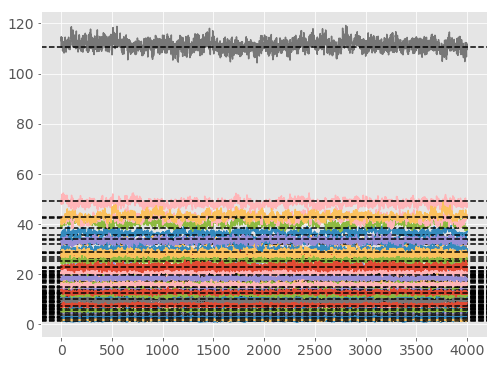

In [19]:
for i in range(1000, 1100):
    plt.plot(v_cwv[i, :])
    plt.gca().axhline(v_cwv_true[i], c = 'k', ls = '--')

In [107]:
v_h2o[118, 250:500, :].shape

(250, 15)

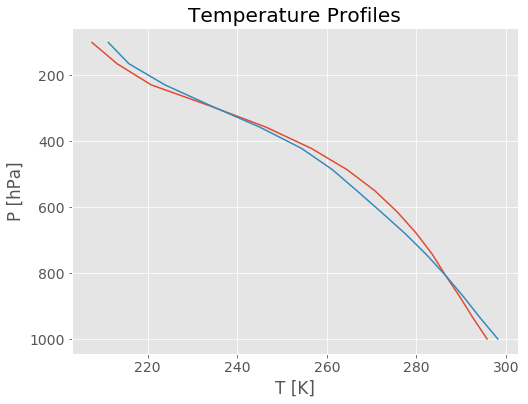

In [38]:
plt.plot(np.mean(profs_t[2, 0:200], axis = 0), p)
plt.plot(np.mean(profs_t[2, 200:400], axis = 0), p)
plt.title("Temperature Profiles")
plt.xlabel("T [K]")
plt.ylabel("P [hPa]")
plt.gca().invert_yaxis()

In [37]:
p = np.load("data/p_grid.npy")
profiles_t[1, :, :].shape

(200, 15)

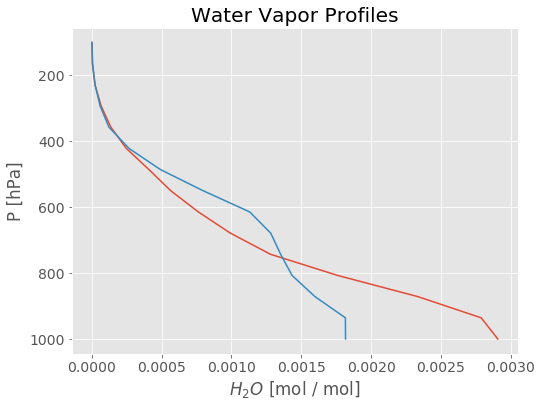

In [145]:
plt.plot(np.mean(np.exp(profs_q[1, 0:200]) * 18.0 / 28.9, axis = 0), p)
plt.plot(np.mean(np.exp(profs_q[1, 200:400]) * 18.0/ 28.9, axis = 0), p)
plt.gca().invert_yaxis()
plt.title("Water Vapor Profiles")
plt.xlabel("$H_2O$ [mol / mol]")
plt.ylabel("P [hPa]")